In [1]:
# make sure you don't hog all the video memory
import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.Session(config=config)
from keras import backend as K
K.set_session(sess)
###################################

from keras.layers import Input, Lambda, merge, Dense, DepthwiseConv2D, Activation, AveragePooling2D
from keras.layers import Flatten,Conv2D, MaxPooling2D, Dropout, BatchNormalization, SeparableConv2D
from keras.constraints import max_norm
from keras.models import Model, Sequential
from keras.regularizers import l2
from keras.initializers import RandomUniform
from keras.optimizers import SGD,Adam
from keras.losses import binary_crossentropy
import numpy.random as rng
import numpy as np
import os
import pickle
import matplotlib.pyplot as plt
# import seaborn as sns
from sklearn.utils import shuffle
%matplotlib inline

Using TensorFlow backend.


In [2]:
SHUFFLE = False
Seed = 4
SCRAMBLE_FOR_TEST = False
AUGMENT = True

file = 'Merged456-197-289_ICA(-eyes)+AUDpreproc.mat, DS2=64Hz, FIR=2-30Hz, centnorm=1, step=2, win=2, TD, 1-93.mat' #0.75(vanilla EEGnet), 0. (SiameseL1)
# file = 'Merged456-1-94_ICA(-2,3ICs)+AUDpreproc.mat, DS2=64Hz, FIR=2-30Hz, centnorm=1, step=2, win=2, TD, 1-95.mat' #0.61(vanilla EEGnet)
# get the Dataset:
import scipy.io as sio
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

path = '/home/amplifier/home/DATASETS/' + file
mat_contents = sio.loadmat(path)
X = mat_contents['X']
Y = mat_contents['Z']

if X.shape[1]<X.shape[2]:
    X = np.transpose(X,[0,2,1])

if Y.shape[1] > Y.shape[0]:
    Y = Y.T

    
# # one hot encode the labels:
# onehot_encoder = preprocessing.OneHotEncoder(sparse=False)
# Y = onehot_encoder.fit_transform(Y)

X = X.transpose(0,2,1)

print('Original data shape:', X.shape)
print('Original labels shape:', Y.shape)


# verify that the model REALLY finds a mapping between the input and the labels. If we get
# our accuracy by chance, then we should get the same accuracy on a permuted dataset:
if SCRAMBLE_FOR_TEST==True:
    Y = np.random.permutation(Y)
Y = Y.flatten()

Original data shape: (450, 60, 128)
Original labels shape: (450, 1)


In [3]:
from itertools import product
from sys import getsizeof

    
def get_pairs(X,Y):
    print('X', X.shape)
    print('Y', Y.shape)
    
    # get the full permutation (very LARGE DATASET!)

    temp = []
    for x in product(range(Y.shape[0]), repeat=2):
        temp.append(np.array(x))
    
    n_perm = len(temp)
    temp = np.array(temp)
    print('temp', temp.shape)

    XX = np.zeros([n_perm,2,60,128])
    XX[:,0,:,:] = X[[temp[i,0] for i in range(n_perm)],:,:]
    XX[:,1,:,:] = X[[temp[i,1] for i in range(n_perm)],:,:]

    print('Data size in memory (GB):', np.round(getsizeof(XX)/1024/1024/1024, 2))

    YY = np.zeros([n_perm, 2])
    YY[:,0] = Y[[temp[i,0] for i in range(n_perm)]].flatten()
    YY[:,1] = Y[[temp[i,1] for i in range(n_perm)]].flatten()

    YYY = []
    for i in range(len(YY)):
        YYY.append(0 if YY[i,0]==YY[i,1] else 1)
    YYY = np.array(YYY).flatten()
    
    # diag:
#     print (XX.shape, YYY.shape)
#     for i in range(XX.shape[0]):
#         print(temp[i,0], YY[i,0], temp[i,1], YY[i,1], YYY[i])

    print('Left Col', np.mean(YY[:,0]))
    print('Right Col', np.mean(YY[:,1]))
    print('Labels', np.mean(YYY), '\n')
    
    print("\nPairs", XX.shape)
    print("Labels", YYY.shape)
    
    return XX, YYY

In [4]:
x_train, x_test, y_train, y_test, = train_test_split(X, Y, test_size=0.1, shuffle=True)

print(x_train.shape)
print(x_test.shape)

print(y_train.shape)
print(y_test.shape)

(405, 60, 128)
(45, 60, 128)
(405,)
(45,)


In [5]:
X_test, Y_test = get_pairs(x_test, y_test)
X_train, Y_train = get_pairs(x_train, y_train)

X (45, 60, 128)
Y (45,)
temp (2025, 2)
Data size in memory (GB): 0.23
Left Col 0.4888888888888889
Right Col 0.4888888888888889
Labels 0.4997530864197531 


Pairs (2025, 2, 60, 128)
Labels (2025,)
X (405, 60, 128)
Y (405,)
temp (164025, 2)
Data size in memory (GB): 18.77
Left Col 0.5012345679012346
Right Col 0.5012345679012346
Labels 0.4999969516841945 


Pairs (164025, 2, 60, 128)
Labels (164025,)


In [6]:
# print(X.shape)
# val_set = np.random.choice(range(len(Y)), 50, replace=False)
# print(val_set.shape)
# X_val = X[val_set,:,:]
# Y_val = Y[val_set]
# print('Validation Set')
# print('X_val:', X_val.shape)
# print('Y_val:', Y_val.shape)

# X = np.delete(X,val_set,0)
# Y = np.delete(Y,val_set,0)
# print('Train & Test')
# print(X.shape)
# print(Y.shape)

In [7]:
# SZ = 195
# idx_a = []
# idx_b = []
# idy_a = []
# idy_b = []
# YYY = []
# for i in range(2):
#     addr = np.array(np.where(Y==i)).flatten()
#     a = np.random.choice(addr, size=SZ, replace=False).tolist()
#     b = np.random.choice(addr, size=SZ, replace=False).tolist()
#     idx_a = idx_a + a
#     idx_b = idx_b + b
#     idy_a = idy_a + a
#     idy_b = idy_b + b

# for i in range(2):
#     addr_a = np.array(np.where(Y==i)).flatten()
#     addr_b = np.array(np.where(Y!=i)).flatten()
#     a = np.random.choice(addr_a, size=SZ, replace=False).tolist()
#     b = np.random.choice(addr_b, size=SZ, replace=False).tolist()
#     idx_a = idx_a + a
#     idx_b = idx_b + b
#     idy_a = idy_a + a
#     idy_b = idy_b + b
    
# XX = [X[idx_a], X[idx_b]]
# YY = [Y[idy_a], Y[idy_b]]

# for i in range(len(idx_a)):
#     YYY.append(0 if YY[0][i]==YY[1][i] else 1)
# YYY = np.array(YYY)

In [8]:
# for i in range(len(idy_a)):
#     print(i, idy_a[i], idy_b[i], YY[0][i], YY[1][i], YYY[i])

In [9]:
# rng = np.arange(len(idx_a))
# train_test = 0.8

# # sample ordinal numbers of 
# train_id = np.random.choice(rng ,np.round(len(rng)*train_test).astype('int64'), replace=False)
# test_id = rng[np.isin(rng,train_id, invert=True)]

# x_train = [X[np.array(idx_a)[train_id]], X[np.array(idx_b)[train_id]]]
# x_test = [X[np.array(idx_a)[test_id]], X[np.array(idx_b)[test_id]]]
# y_train = YYY[train_id]
# y_test = YYY[test_id]

# print(len(idx_a))
# print(len(y_train))
# print(len(y_test))

# print(np.mean(y_train))
# print(np.mean(y_test))

# x_train = np.array(x_train).transpose(1,0,2,3)
# x_test = np.array(x_test).transpose(1,0,2,3)
# y_train = np.array(y_train).flatten()
# y_test = np.array(y_test).flatten()

In [10]:
# # get the full permutation (very LARGE DATASET!)
# from itertools import product
# from sys import getsizeof

# temp = []
# for x in product(range(Y.shape[0]), repeat=2):
#     temp.append(np.array(x))

# XX = np.zeros([len(temp), 2, 60, 128])
# XX[:,0,:,:] = X[[temp[i][0] for i in range(len(temp))],:,:]
# XX[:,1,:,:] = X[[temp[i][1] for i in range(len(temp))],:,:]


# print('Data size in memory (GB):', np.round(getsizeof(XX)/1024/1024/1024, 2))

# YY = np.zeros([len(temp), 2])
# YY[:,0] = Y[[temp[i][0] for i in range(len(temp))]].flatten()
# YY[:,1] = Y[[temp[i][1] for i in range(len(temp))]].flatten()

# YYY = []
# for i in range(len(YY)):
#     YYY.append(1 if YY[i,0]==YY[i,1] else 0)
# YYY = np.array(YYY).flatten()

# x_train, x_test, y_train, y_test = train_test_split(XX,YYY, test_size=0.1, shuffle=True, random_state=10)
# print (x_train.shape, y_train.shape, x_test.shape, y_test.shape)

In [11]:
def EEGNet_my(input1, nb_classes, Chans = 64, Samples = 128, 
             dropoutRate = 0.25, kernLength = 64, F1 = 4, 
             D = 2, F2 = 8, dropoutType = 'Dropout'):
    
    """ Keras Implementation of EEGNet (https://arxiv.org/abs/1611.08024)

    Inputs:
        
      nb_classes      : int, number of classes to classify
      Chans, Samples  : number of channels and time points in the EEG data
      dropoutRate     : dropout fraction
      kernLength      : length of temporal convolution in first layer. We found
                        that setting this to be half the sampling rate worked
                        well in practice. For the SMR dataset in particular
                        since the data was high-passed at 4Hz we used a kernel
                        length of 32.     
      F1, F2          : number of temporal filters (F1) and number of pointwise
                        filters (F2) to learn. Default: F1 = 4, F2 = F1 * D. 
      D               : number of spatial filters to learn within each temporal
                        convolution. Default: D = 2
      dropoutType     : Either SpatialDropout2D or Dropout, passed as a string.

    """
    
    if dropoutType == 'SpatialDropout2D':
        dropoutType = SpatialDropout2D
    elif dropoutType == 'Dropout':
        dropoutType = Dropout
    else:
        raise ValueError('dropoutType must be one of SpatialDropout2D '
                         'or Dropout, passed as a string.')
    
    init = RandomUniform(minval=-0.1, maxval=0.1, seed=29)
    net = Sequential()
    net.add (Conv2D(F1, (1, kernLength), padding = 'same',
                                   input_shape = (Chans, Samples,1),
                                   use_bias = False, bias_initializer=init, kernel_initializer=init))
    net.add (BatchNormalization())
    net.add (DepthwiseConv2D((Chans, 1), use_bias = False, 
                                   depth_multiplier = D,
                                   depthwise_constraint = max_norm(1.), bias_initializer=init, kernel_initializer=init))
    net.add (BatchNormalization())
    net.add (Activation('elu'))
    net.add (AveragePooling2D((1, 4)))
    net.add (dropoutType(dropoutRate))
    net.add (SeparableConv2D(F2, (1, 16), use_bias = False, padding = 'same', bias_initializer=init, kernel_initializer=init))
    net.add (BatchNormalization())
    net.add (Activation('elu'))
    net.add (AveragePooling2D((1, 8)))
    net.add (dropoutType(dropoutRate))
    net.add (Flatten())
    net.add (Dense(nb_classes, kernel_constraint = max_norm(0.25), bias_initializer=init, kernel_initializer=init))
    return net

In [12]:
from keras.engine.topology import Layer
from keras.layers import Concatenate

# def triplet_loss(y_true, y_pred):
#     norm1 = K.sqrt(K.sum(K.square(y_pred[0] - y_pred[1]), axis=-1, keepdims=True))
#     norm2 = K.sqrt(K.sum(K.square(y_pred[0] - y_pred[2]), axis=-1, keepdims=True))
#     loss = norm1 - norm2 + 0.2
#     return loss

input_shape = X_train[-1,-1,:,:].shape + (1,)
a_input = Input(input_shape)
r_input = Input(input_shape)

#call the convnet Sequential model on each of the input tensors so params will be shared
# encoded NOT as Sequential (stack of layers), but as a Tensor!!!! if you add an argument, a Tensor is returned
encoded_a = EEGNet_my(input_shape, 10, Chans=input_shape[0])(a_input)
encoded_r = EEGNet_my(input_shape, 10, Chans=input_shape[0])(r_input)

L1_distance = Lambda(lambda tensors: (K.abs(tensors[0] - tensors[1])))([encoded_a, encoded_r])
L1_distance = Dense(1,activation='sigmoid', use_bias=True)(L1_distance)

# siamese_net = Model(inputs=[a_input, r_input], outputs=[encoded_a, encoded_r, L1_distance])
siamese_net = Model(inputs=[a_input, r_input], outputs=[L1_distance])
optimizer = Adam(0.00006)
# optimizer = 'adam'
siamese_net.compile(loss=['binary_crossentropy'], optimizer=optimizer, metrics=['accuracy'])
siamese_net.summary()

a1 = np.linalg.norm(siamese_net.layers[2].layers[13].get_weights()[0])
a2 = np.linalg.norm(siamese_net.layers[3].layers[13].get_weights()[0])
print(a1, a2)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 60, 128, 1)   0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 60, 128, 1)   0                                            
__________________________________________________________________________________________________
sequential_1 (Sequential)       (None, 10)           1338        input_1[0][0]                    
__________________________________________________________________________________________________
sequential_2 (Sequential)       (None, 10)           1338        input_2[0][0]                    
__________________________________________________________________________________________________
lambda_1 (

In [13]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

early_stopping = EarlyStopping(monitor='val_acc', patience=20, mode='min')
checkpointer = ModelCheckpoint(filepath='/home/amplifier/home/NEW_DL/weights/Siam3EEGnet_wts.h5',
                               verbose=1,
                               monitor='val_acc',
                               save_best_only=True)

train_history = siamese_net.fit([X_train[:,0,:,:,None], X_train[:,1,:,:,None]], Y_train,
                epochs=100,
                batch_size=20,
                verbose=1,
                shuffle=True,
                validation_data=([X_test[:,0,:,:,None], X_test[:,1,:,:,None]], Y_test),
                callbacks=[checkpointer, early_stopping])

# model.save('/home/amplifier/home/NEW_DL/models/Siam3.h5')

Train on 164025 samples, validate on 2025 samples
Epoch 1/100
164025/164025 [==============================] - 142s 865us/step - loss: 0.6934 - acc: 0.5004 - val_loss: 0.6929 - val_acc: 0.5146

Epoch 00002: val_acc improved from 0.50914 to 0.51457, saving model to /home/amplifier/home/NEW_DL/weights/Siam3EEGnet_wts.h5
Epoch 3/100
 76260/164025 [============>.................] - ETA: 1:15 - loss: 0.6934 - acc: 0.5035

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



164025/164025 [==============================] - 141s 862us/step - loss: 0.6933 - acc: 0.5004 - val_loss: 0.6932 - val_acc: 0.4973

Epoch 00005: val_acc did not improve from 0.51457
Epoch 6/100
 47240/164025 [=======>......................] - ETA: 1:40 - loss: 0.6933 - acc: 0.4982

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



164025/164025 [==============================] - 142s 863us/step - loss: 0.6933 - acc: 0.5010 - val_loss: 0.6934 - val_acc: 0.5022

Epoch 00007: val_acc did not improve from 0.51457
Epoch 8/100
152520/164025 [==========================>...] - ETA: 9s - loss: 0.6932 - acc: 0.5021

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



164025/164025 [==============================] - 141s 857us/step - loss: 0.6924 - acc: 0.5165 - val_loss: 0.6951 - val_acc: 0.4909

Epoch 00010: val_acc did not improve from 0.51457
Epoch 11/100
119680/164025 [====================>.........] - ETA: 37s - loss: 0.6817 - acc: 0.5665

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



164025/164025 [==============================] - 141s 861us/step - loss: 0.5740 - acc: 0.7038 - val_loss: 0.6630 - val_acc: 0.6365

Epoch 00013: val_acc improved from 0.53926 to 0.63654, saving model to /home/amplifier/home/NEW_DL/weights/Siam3EEGnet_wts.h5
Epoch 14/100
 66300/164025 [===========>..................] - ETA: 1:23 - loss: 0.5229 - acc: 0.7447

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



164025/164025 [==============================] - 141s 860us/step - loss: 0.3755 - acc: 0.8367 - val_loss: 0.8731 - val_acc: 0.5694

Epoch 00016: val_acc did not improve from 0.63654
Epoch 17/100
 34720/164025 [=====>........................] - ETA: 1:50 - loss: 0.3472 - acc: 0.8521

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



164025/164025 [==============================] - 141s 859us/step - loss: 0.2909 - acc: 0.8786 - val_loss: 1.0154 - val_acc: 0.6163

Epoch 00018: val_acc did not improve from 0.63654
Epoch 19/100
164025/164025 [==============================] - 141s 859us/step - loss: 0.2598 - acc: 0.8932 - val_loss: 1.0604 - val_acc: 0.6049

Epoch 00019: val_acc did not improve from 0.63654
Epoch 20/100
  3380/164025 [..............................] - ETA: 2:17 - loss: 0.2552 - acc: 0.8956

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



164025/164025 [==============================] - 141s 858us/step - loss: 0.2195 - acc: 0.9109 - val_loss: 1.1903 - val_acc: 0.5872

Epoch 00021: val_acc did not improve from 0.63654
Epoch 22/100
109800/164025 [===================>..........] - ETA: 46s - loss: 0.2022 - acc: 0.9191

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



164025/164025 [==============================] - 141s 857us/step - loss: 0.1728 - acc: 0.9321 - val_loss: 1.2949 - val_acc: 0.5669

Epoch 00024: val_acc did not improve from 0.63654
Epoch 25/100
 88140/164025 [===============>..............] - ETA: 1:04 - loss: 0.1621 - acc: 0.9368

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



164025/164025 [==============================] - 141s 858us/step - loss: 0.1450 - acc: 0.9439 - val_loss: 1.4329 - val_acc: 0.5640

Epoch 00027: val_acc did not improve from 0.63654
Epoch 28/100
 54920/164025 [=========>....................] - ETA: 1:33 - loss: 0.1441 - acc: 0.9443

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



164025/164025 [==============================] - 141s 861us/step - loss: 0.1335 - acc: 0.9488 - val_loss: 1.4385 - val_acc: 0.5773

Epoch 00029: val_acc did not improve from 0.63654


In [ ]:
siamese_net.load_weights('/home/amplifier/home/NEW_DL/weights/Siam3_wts.h5')

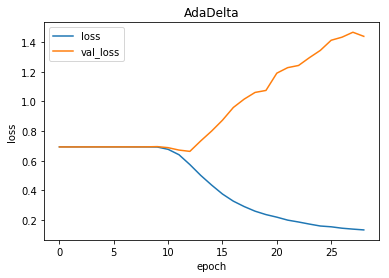

In [14]:
# print(np.array(history.losses))
import matplotlib.pyplot as plt
%matplotlib inline
loss = train_history.history['loss']
val_loss = train_history.history['val_loss']
plt.plot(loss)
plt.plot(val_loss)
plt.legend(['loss', 'val_loss'])
plt.title('AdaDelta')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

In [15]:
train_acc = []
rng = np.random.choice(y_train.shape[0], 195, replace=False)
prediction = []
for i in rng:
    pred = siamese_net.predict([x_train[None,i,0,:,:,None], x_train[None,i,1,:,:,None]])
    prediction.append(pred)
    acc = 'correct' if np.round(pred)==y_train[i] else ""
    train_acc.append(1 if np.round(pred)==y_train[i] else 0)
#     print(i, pred, np.round(pred), y_train[i], acc)
print('Train Accuracy', np.mean(train_acc))

IndexError: too many indices for array

In [92]:
test_acc = []
rng = np.random.choice(y_test.shape[0], 190, replace=False)
prediction = []
for i in rng:
    pred = siamese_net.predict([x_test[None,i,0,:,:,None], x_test[None,i,1,:,:,None]])
    prediction.append(pred)
    acc = 'correct' if np.round(pred)==y_train[i] else ""
    test_acc.append(1 if np.round(pred)==y_train[i] else 0)
#     print(i, pred, np.round(pred), y_test[i], acc)
print('Test Accuracy', np.mean(test_acc))

ValueError: Cannot take a larger sample than population when 'replace=False'

In [192]:
val_acc = []
for k in range(len(Y_val)):
    i = np.random.randint(len(Y_val))
    j = np.random.randint(len(Y_val))
    pred = siamese_net.predict([X_val[None,i,:,:,None], X_val[None,j,:,:,None]])
    correct = 1 if Y_val[i]==Y_val[j] and np.round(pred)==0 or Y_val[i]!=Y_val[j] and np.round(pred)==1  else 0
    val_acc.append(correct)
    print(i, pred, Y_val[i], Y_val[j], correct)
print('Validation accuracy:', np.mean(val_acc))

3 [[0.9992372]] [1] [1] 0
7 [[0.00024588]] [1] [1] 1
21 [[0.46680015]] [0] [0] 1
14 [[0.01244232]] [1] [0] 0
36 [[0.04232696]] [1] [0] 0
29 [[0.99990094]] [1] [0] 1
19 [[0.1772979]] [1] [1] 1
12 [[0.9069365]] [1] [1] 0
37 [[0.7378922]] [0] [1] 1
36 [[0.29272014]] [1] [1] 1
15 [[0.04256096]] [0] [0] 1
28 [[0.53658324]] [0] [0] 0
29 [[0.9999231]] [1] [0] 1
18 [[0.00088351]] [0] [1] 0
30 [[0.9805331]] [0] [0] 0
10 [[0.9360994]] [0] [0] 0
18 [[0.99991226]] [0] [0] 0
44 [[0.00152636]] [1] [0] 0
37 [[0.9978452]] [0] [0] 0
47 [[0.78717244]] [0] [0] 0
2 [[0.9994961]] [0] [1] 1
12 [[0.8994222]] [1] [1] 0
41 [[0.7775418]] [1] [1] 0
36 [[0.99999964]] [1] [1] 0
35 [[0.00529279]] [1] [1] 1
0 [[0.9932267]] [0] [0] 0
8 [[0.9999838]] [0] [1] 1
28 [[0.00052391]] [0] [1] 0
8 [[0.9998846]] [0] [1] 1
18 [[0.9999815]] [0] [1] 1
12 [[0.46604905]] [1] [0] 0
3 [[0.8300947]] [1] [1] 0
25 [[0.00095356]] [1] [1] 1
43 [[0.9842917]] [1] [1] 0
11 [[8.524662e-05]] [0] [0] 1
3 [[0.9992888]] [1] [1] 0
44 [[0.9985189]]

In [53]:
def EEGNet(nb_classes, Chans = 64, Samples = 128, 
             dropoutRate = 0.25, kernLength = 64, F1 = 4, 
             D = 2, F2 = 8, dropoutType = 'Dropout'):
    """ Keras Implementation of EEGNet (https://arxiv.org/abs/1611.08024)

    Inputs:
        
      nb_classes      : int, number of classes to classify
      Chans, Samples  : number of channels and time points in the EEG data
      dropoutRate     : dropout fraction
      kernLength      : length of temporal convolution in first layer. We found
                        that setting this to be half the sampling rate worked
                        well in practice. For the SMR dataset in particular
                        since the data was high-passed at 4Hz we used a kernel
                        length of 32.     
      F1, F2          : number of temporal filters (F1) and number of pointwise
                        filters (F2) to learn. Default: F1 = 4, F2 = F1 * D. 
      D               : number of spatial filters to learn within each temporal
                        convolution. Default: D = 2
      dropoutType     : Either SpatialDropout2D or Dropout, passed as a string.

    """
    
    if dropoutType == 'SpatialDropout2D':
        dropoutType = SpatialDropout2D
    elif dropoutType == 'Dropout':
        dropoutType = Dropout
    else:
        raise ValueError('dropoutType must be one of SpatialDropout2D '
                         'or Dropout, passed as a string.')
    
    input1   = Input(shape = (1, Chans, Samples))

    ##################################################################
    block1       = Conv2D(F1, (1, kernLength), padding = 'same',
                                   input_shape = (1, Chans, Samples),
                                   use_bias = False, data_format='channels_first')(input1)
    block1       = BatchNormalization(axis = 1)(block1)
    block1       = DepthwiseConv2D((Chans, 1), use_bias = False, 
                                   depth_multiplier = D,
                                   depthwise_constraint = max_norm(1.), data_format='channels_first')(block1)
    block1       = BatchNormalization(axis = 1)(block1)
    block1       = Activation('elu')(block1)
    block1       = AveragePooling2D((1, 4), data_format='channels_first')(block1)
    block1       = dropoutType(dropoutRate)(block1)
    
    block2       = SeparableConv2D(F2, (1, 16),
                                   use_bias = False,
                                   padding = 'same',
                                   data_format='channels_first')(block1)
    block2       = BatchNormalization(axis = 1)(block2)
    block2       = Activation('elu')(block2)
    block2       = AveragePooling2D((1, 8), data_format='channels_first')(block2)
    block2       = dropoutType(dropoutRate)(block2)
        
    flatten      = Flatten(name = 'flatten')(block2)
    
    dense        = Dense(nb_classes, name = 'dense', 
                         kernel_constraint = max_norm(0.25))(flatten)
    softmax      = Activation('softmax', name = 'softmax')(dense)
    
    return Model(inputs=input1, outputs=softmax)

model  = EEGNet(nb_classes = 2,
                Chans = 60,
                Samples = 128,
                kernLength = 125)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_33 (InputLayer)        (None, 1, 60, 128)        0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 4, 60, 128)        500       
_________________________________________________________________
batch_normalization_28 (Batc (None, 4, 60, 128)        16        
_________________________________________________________________
depthwise_conv2d_10 (Depthwi (None, 8, 1, 128)         480       
_________________________________________________________________
batch_normalization_29 (Batc (None, 8, 1, 128)         32        
_________________________________________________________________
activation_15 (Activation)   (None, 8, 1, 128)         0         
_________________________________________________________________
average_pooling2d_14 (Averag (None, 8, 1, 32)          0         
__________

In [299]:
def TrainTestVal_Split(leng, traintest, testval):
    leng = 100
    x = np.arange(leng)
    train_id, test_id, val_id = np.split(
        x,[np.round(leng*traintest).astype(int),
           np.round(leng*testval).astype(int)])
    return train_id, test_id, val_id

# train_id, test_id, val_id = TrainTestVal_Split(100, 0.8, 0.9)
# print(train_id)
# print(test_id)
# print(val_id)

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49
 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74
 75 76 77 78 79]
[80 81 82 83 84 85 86 87 88 89]
[90 91 92 93 94 95 96 97 98 99]


In [834]:
for j in range(xx_train.shape[0]):
    hit = []
    for i in range(X.shape[0]):
        if np.linalg.norm(X[i,:,:] - xx_train[j,0,:,:])==0:
            hit.append(i)
            print(hit)
            print('success' if np.linalg.norm(Y[i] - yy_train[j])==0 else 'FAIL!')

[418]
success
[437]
success
[75]
success
[405]
success
[96]
success
[216]
success
[193]
success
[246]
success
[144]
success
[155]
success
[162]
success
[191]
success
[258]
success
[309]
success
[126]
success
[299]
success
[52]
success
[340]
success
[156]
success
[281]
success
[121]
success
[163]
success
[107]
success
[104]
success
[279]
success
[10]
success
[264]
success
[376]
success
[428]
success
[101]
success
[217]
success
[168]
success
[39]
success
[303]
success
[304]
success
[61]
success
[18]
success
[305]
success
[212]
success
[272]
success
[188]
success
[67]
success
[86]
success
[354]
success
[411]
success
[439]
success
[291]
success
[82]
success
[365]
success
[149]
success
[238]
success
[59]
success
[146]
success
[209]
success
[170]
success
[298]
success
[140]
success
[268]
success
[307]
success
[100]
success
[420]
success
[192]
success
[23]
success
[416]
success
[175]
success
[80]
success
[438]
success
[345]
success
[399]
success
[447]
success
[359]
success
[445]
success
[444]

KeyboardInterrupt: 

In [6]:
def train_augment(xx_train, yy_train):
    print('Before augmenting', xx_train.shape)
    temp_xx = np.concatenate([xx_train, xx_train, xx_train, xx_train, xx_train], axis=0)
    print(temp_xx.shape)
    temp_xx_0 = temp_xx[:,0,:,:]
    temp_xx_0 = temp_xx_0.reshape(temp_xx_0.shape + (1,)).transpose(0,3,1,2)
    print(temp_xx_0.shape)

    temp_xx_1 = temp_xx[:,1,:,:]
    np.random.shuffle(temp_xx_1)
    temp_xx_1 = temp_xx_1.reshape(temp_xx_1.shape + (1,)).transpose(0,3,1,2)
    print(temp_xx_1.shape)

    xx_train_aug = np.concatenate([temp_xx_0, temp_xx_1], axis=1)
    print('After augmenting', xx_train_aug.shape)
    print(xx_train_aug.shape)

    yy_train_aug = np.concatenate([yy_train, yy_train, yy_train, yy_train, yy_train], axis=0)
    print('yy_train_aug', yy_train_aug.shape)
    return xx_train_aug, yy_train_aug

if AUGMENT==True:
    xx_train, yy_train = train_augment(xx_train, yy_train)
    print('\nAfter augmenting:\n', xx_train.shape,'\n', yy_train.shape )

Before augmenting (324, 2, 60, 128)
(1620, 2, 60, 128)
(1620, 1, 60, 128)
(1620, 1, 60, 128)
After augmenting (1620, 2, 60, 128)
(1620, 2, 60, 128)
yy_train_aug (1620, 2)

After augmenting:
 (1620, 2, 60, 128) 
 (1620, 2)


In [4]:
a,b = [],[]
for i in range(len(X)):
    if np.array_equal(Y[i],np.array([0,1])):
        a.append(i)
    if np.array_equal(Y[i],np.array([1,0])):
        b.append(i)    

In [5]:
XX_a = np.zeros([len(a),2,X.shape[1],X.shape[2]])
XX_b = np.zeros([len(b),2,X.shape[1],X.shape[2]])
XX = np.zeros([len(a)+len(b),2,X.shape[1],X.shape[2]])

YY_a = np.zeros([len(a),2])
YY_b = np.zeros([len(b),2])
YY = np.zeros([len(b)+len(b),2])

XX_a[:,0,:,:] = X[a,:,:]
XX_a[:,1,:,:] = X[np.random.permutation(a),:,:]
YY_a = Y[a]
XX_b[:,0,:,:] = X[b,:,:]
XX_b[:,1,:,:] = X[np.random.permutation(b),:,:]
YY_b = Y[b]

XX = np.concatenate([XX_a, XX_b], axis=0)
YY = np.concatenate([YY_a, YY_b], axis=0)

print('XX_a\t', XX_a.shape)
print('XX_b\t', XX_b.shape)
print('XX\t', XX.shape)

train_id, test_id, val_id = train_test_val(XX,YY, 0.2, 0.1, shuffle=SHUFFLE)

xx_train = XX[train_id,:,:,:]
yy_train = YY[train_id]

xx_test = XX[test_id,:,:,:]
yy_test = YY[test_id]

xx_val = XX[val_id,:,:,:]
yy_val = YY[val_id]

print('\nXX_trai\t', xx_train.shape)
print('XX_test\t', xx_test.shape)
print('XX_val\t', xx_val.shape)
print('yy_trai\t', yy_train.shape)
print('yy_test\t', yy_test.shape)
print('yy_val\t', yy_val.shape)

print('\nIf you use RANDOM SEED, check if you generate the same numbers every time:')
print(train_id)
print(test_id)
print(val_id)

XX_a	 (225, 2, 60, 128)
XX_b	 (225, 2, 60, 128)
XX	 (450, 2, 60, 128)

XX_trai	 (324, 2, 60, 128)
XX_test	 (81, 2, 60, 128)
XX_val	 (45, 2, 60, 128)
yy_trai	 (324, 2)
yy_test	 (81, 2)
yy_val	 (45, 2)

If you use RANDOM SEED, check if you generate the same numbers every time:
[291 144  54 215 210 167 184 442 273  96  62 420 255  76 278  86 270 152
 122 325  48 326 264 110 436  31 410 214 361 257 357  73 407 205 115  97
 172 303 285   9 242  59 366 119 118 348 267 141  26 345 447 437 224 446
 178 189 359 245 107 262 108 330 432 272 364 250 279 346  80 388 439 206
 171  33  29 164 258 235 336  13  74  45 406 415 434 317 183 374  92 193
 208 219 428  99 225 368  51 256 342  19 394 237  44 360 132 192 315  11
 296 414 431 424 169 367   4 412 133 283  68 234 397   5 395 328 101 288
  40 165 248 112 449 307 148 308 377 157 309 338 204 320 339 127  64 221
 135 378 401  77 159 353 236 138 381  93  25 408 337 413 117 260  58 444
  79 266 306 318  47 386 227 251  72 292 380 203 387 176 179 399  5